In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,label_binarize
from sklearn.inspection import permutation_importance

import os

sns.set(style="whitegrid")

In [2]:
data_path='synthetic_medical_symptoms_dataset.csv'
try:
    df=pd.read_csv(data_path, encoding='ascii',delimiter=',')
    print('Dataset loaded')
except Exception as e:
    print('Loading dataset failed: ',e)
df.head(5)

Dataset loaded


,age,gender,fever,cough,fatigue,headache,muscle_pain,nausea,vomiting,diarrhea,...,diastolic_bp,heart_rate,temperature_c,oxygen_saturation,wbc_count,hemoglobin,platelet_count,crp_level,glucose_level,diagnosis
0,52,Female,1,0,2,0,0,3,0,3,...,68.0,79.0,36.2,99.0,5.32,13.47,335.0,3.95,119.0,Dengue
1,15,Male,0,0,1,0,1,0,1,0,...,72.0,79.0,37.6,97.0,10.31,14.73,273.0,18.03,104.0,Dengue
2,72,Female,0,2,2,0,2,3,1,1,...,76.0,70.0,37.1,94.0,7.03,11.10,307.0,22.77,120.0,Influenza
3,61,Female,2,0,0,1,0,1,2,1,...,67.0,98.0,36.2,96.0,7.23,12.55,221.0,5.83,97.0,COVID-19
4,21,Female,0,0,0,0,2,3,1,1,...,77.0,103.0,35.0,96.0,9.37,12.69,280.0,16.14,128.0,Dengue


In [3]:
print('Data  types: ')
print(df.dtypes)
print('\nMissing values in each column:')
print(df.isnull().sum())

numeric_columns = ['age', 'fever', 'cough', 'fatigue', 'headache', 'muscle_pain', 
                   'nausea', 'vomiting', 'diarrhea', 'skin_rash', 'loss_smell', 
                   'loss_taste', 'systolic_bp', 'diastolic_bp', 'heart_rate', 
                   'temperature_c', 'oxygen_saturation', 'wbc_count', 'hemoglobin', 
                   'platelet_count', 'crp_level', 'glucose_level']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col],errors ='coerce')

print('\nMissing values after conversion:')
print(df[numeric_columns].isnull().sum())

df.dropna(inplace = True)
print('\nShape of dataframe after dropping missing values:', df.shape)

Data  types: 
age                    int64
gender                object
fever                  int64
cough                  int64
fatigue                int64
headache               int64
muscle_pain            int64
nausea                 int64
vomiting               int64
diarrhea               int64
skin_rash              int64
loss_smell             int64
loss_taste             int64
systolic_bp          float64
diastolic_bp         float64
heart_rate           float64
temperature_c        float64
oxygen_saturation    float64
wbc_count            float64
hemoglobin           float64
platelet_count       float64
crp_level            float64
glucose_level        float64
diagnosis             object
dtype: object

Missing values in each column:
age                  0
gender               0
fever                0
cough                0
fatigue              0
headache             0
muscle_pain          0
nausea               0
vomiting             0
diarrhea             0
skin_rash     

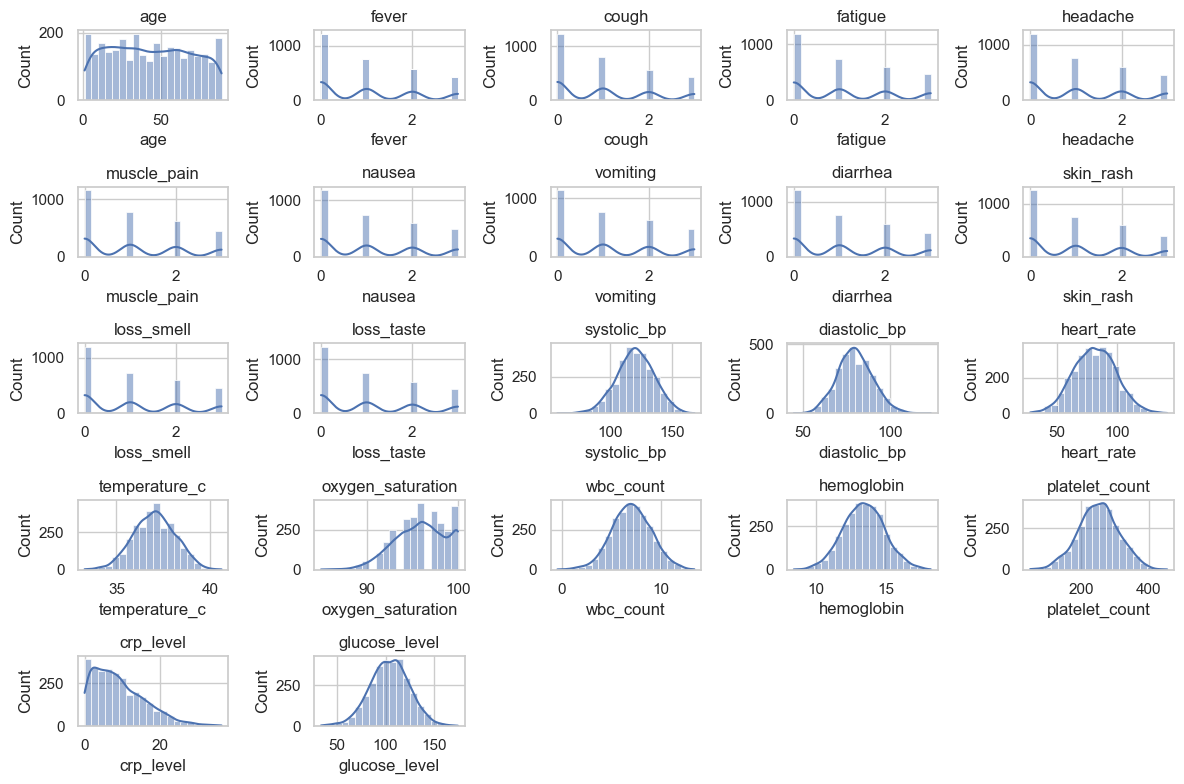

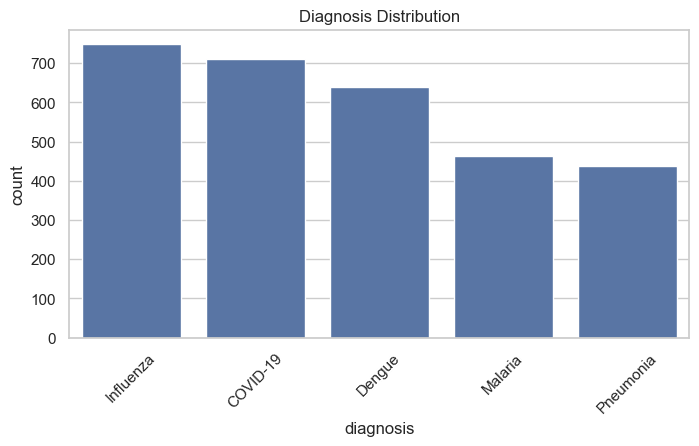

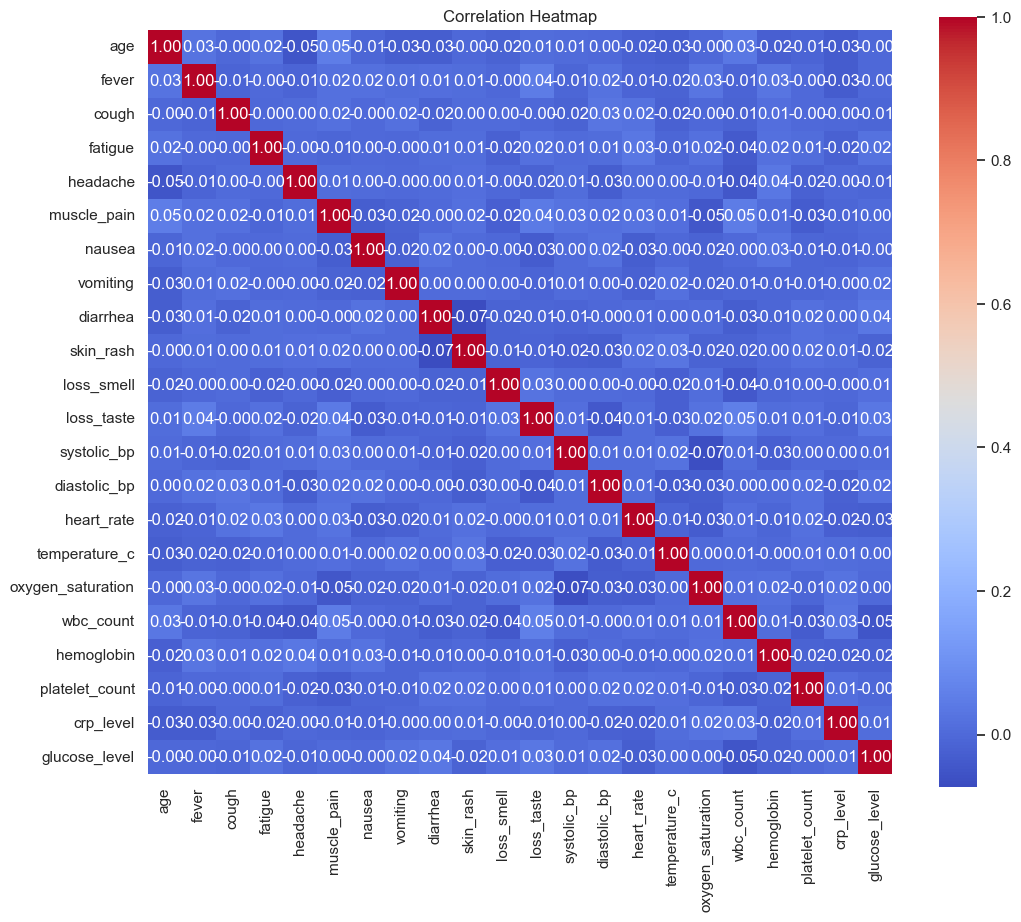

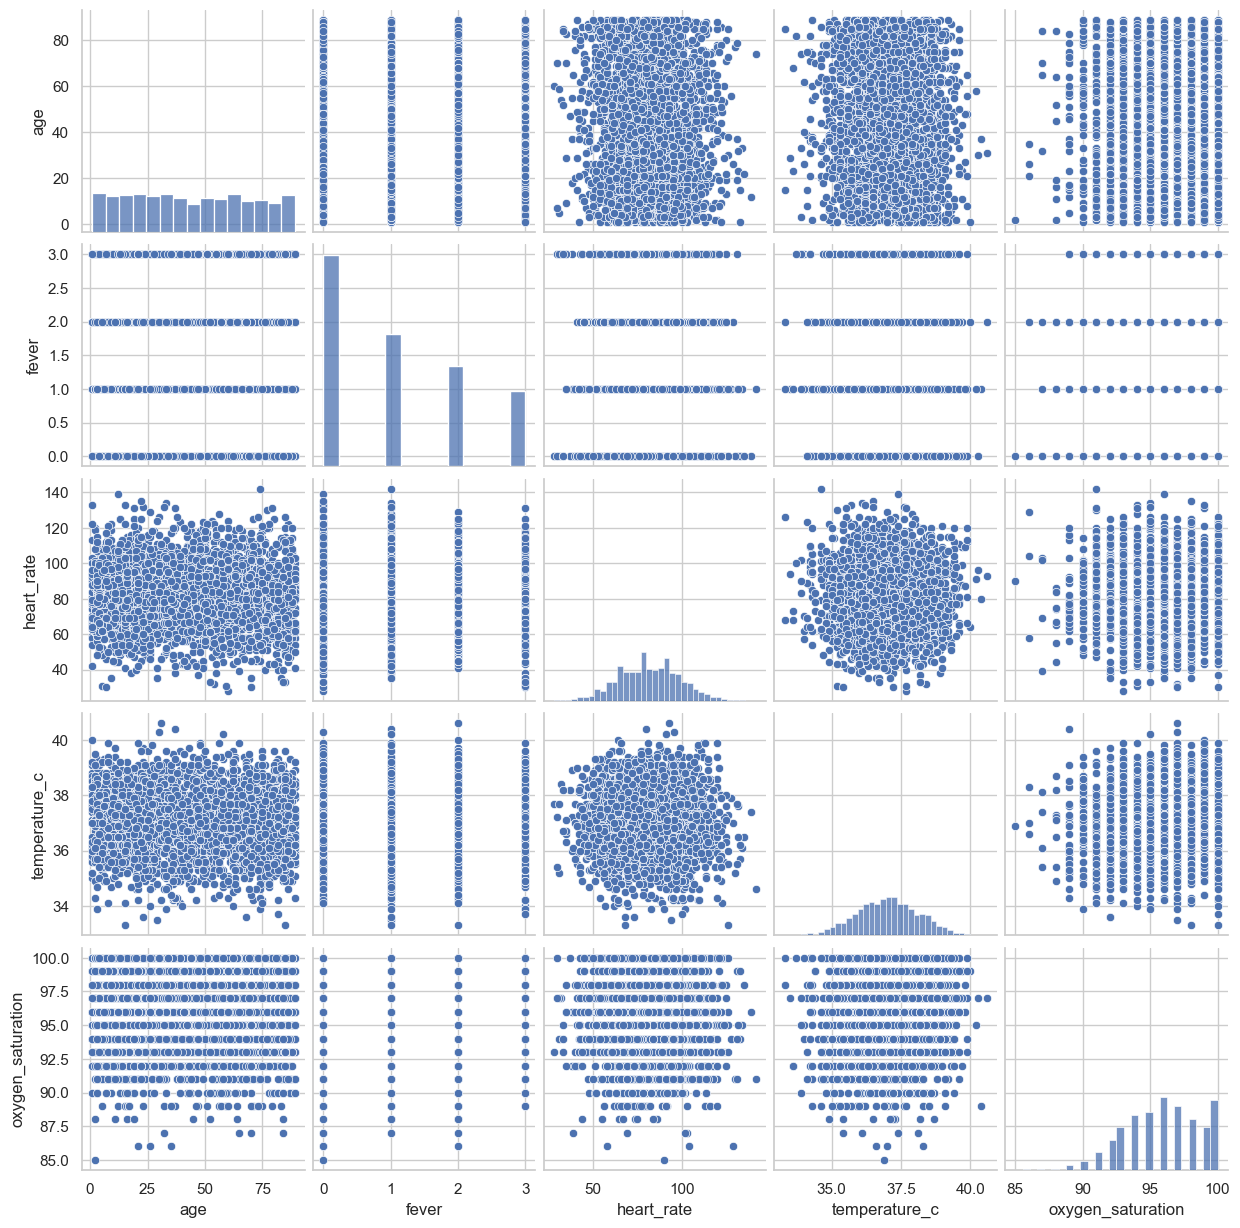

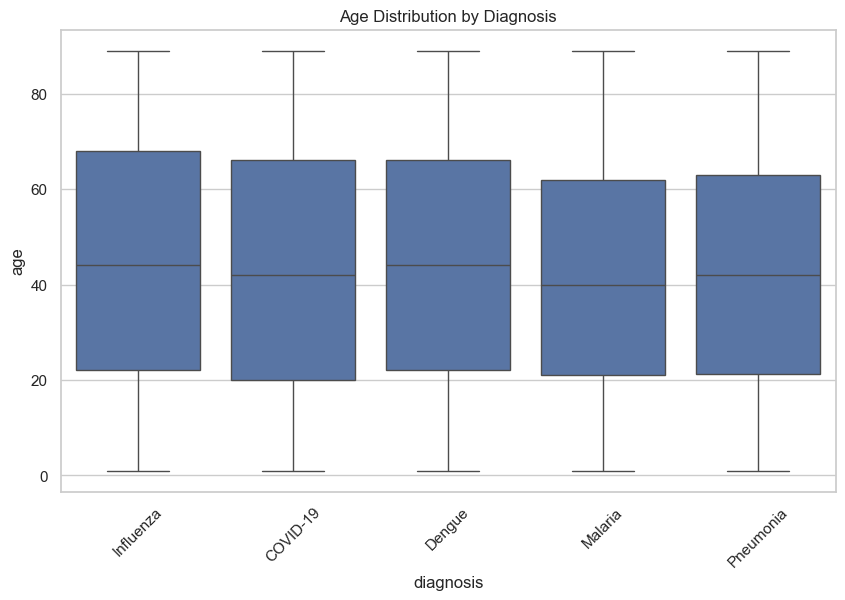

In [4]:
#Histograms for numeric features
plt.figure(figsize=(12,8))
for i,col in enumerate(numeric_columns):
    plt.subplot(5,5,i+1)
    sns.histplot(df[col],kde=True,bins=20)
    plt.title(col)
    plt.tight_layout()
plt.show()

#Count plot for categorical variable 'diagnosis'
plt.figure(figsize = (8,4))
sns.countplot(data=df,x='diagnosis',order = df['diagnosis'].value_counts().index)
plt.title('Diagnosis Distribution')
plt.xticks(rotation = 45)
plt.show()

# Heatmap of correlation for numeric features if there are 4 or more numeric columns
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize = (12,10))
    corr = numeric_df.corr()
    sns.heatmap(corr,annot = True, fmt = '.2f',cmap = 'coolwarm',square = True)
    plt.title('Correlation Heatmap')
    plt.show()

# Pair Plot for a subset of features (for performance reasons)
sample_cols = ['age','fever','heart_rate','temperature_c','oxygen_saturation']
sns.pairplot(df[sample_cols])
plt.show()

# Box Plot to visualize distribution of age across diagnosis
plt.figure(figsize = (10,6))
sns.boxplot(x='diagnosis', y='age', data=df, order=df['diagnosis'].value_counts().index)
plt.title('Age Distribution by Diagnosis')
plt.xticks(rotation=45)
plt.show()

Accuracy Score: 0.24166666666666667


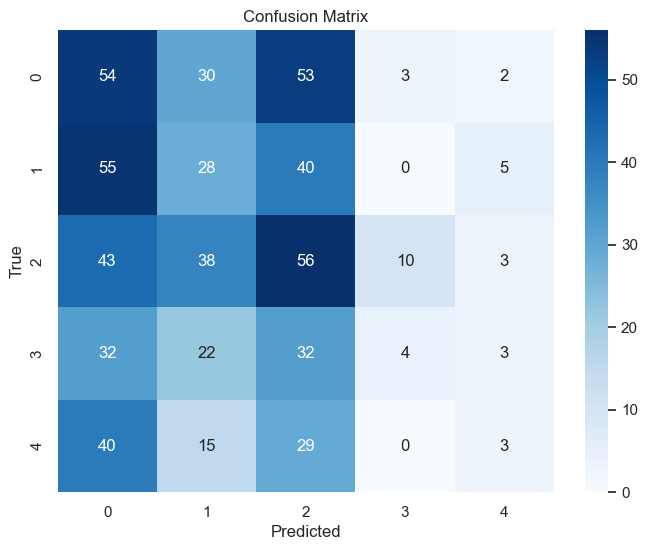

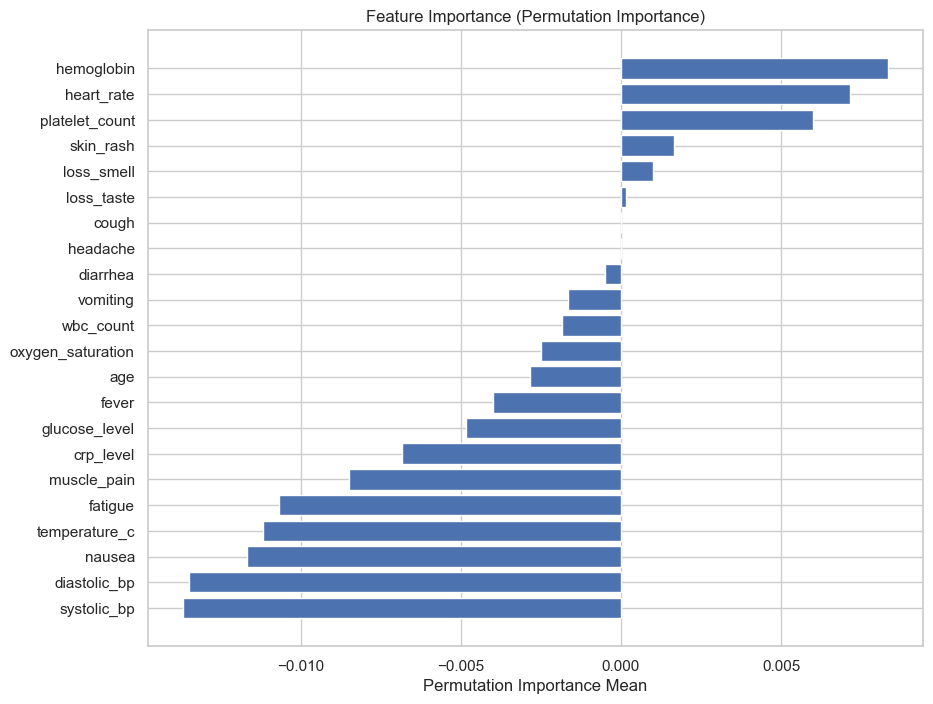

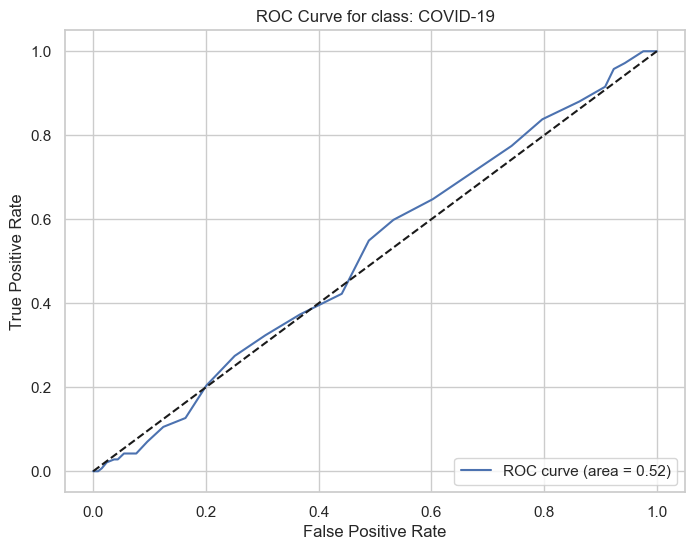

In [5]:
#Building a classification model to predict the diagnosis

X = df.drop(['diagnosis', 'gender'], axis=1)
y = df['diagnosis']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size = 0.2,random_state = 42,stratify=y_encoded)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy Score:', acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

perm_importance = permutation_importance(rf_clf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('Permutation Importance Mean')
plt.title('Feature Importance (Permutation Importance)')
plt.show()

from sklearn.preprocessing import label_binarize

classes = np.unique(y_encoded)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = rf_clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test_binarized[:, 0], y_score[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for class: ' + le.inverse_transform([0])[0])
plt.legend(loc='lower right')
plt.show()